## Laboratorium 8.2


## Przepływ optyczny i śledzenie obiektów

### Wprowadzenie

Metodę przepływu optycznego (między innymi) można stosować również do śledzenia obiektów. Zazwyczaj wykorzystuje się w tym celu metody rzadkie połączone ze znanymi już nam metodami detekcji punktów zainteresowania. Procedura przebiega podobnie jak w przypadku gęstego przepływu (tzn. operujemy na parze klatek w skali szarości, znajdujemy wektory przesunięć), z tą różnicą że obliczanie przepływu zachodzi wyłącznie dla interesujących nas punktów - a zatem musimy znać ich położenia, aby zainicjować proces. Można sobie wyobrazić różne sposoby zlokalizowania punktów kluczowych, w zależności od konkretnego zastosowania i założeń: być może np. pipeline do przetwarzania rozpoczyna się od zlokalizowania jakichś obiektów, być może z góry wiemy, gdzie obiekty się znajdują.

W OpenCV podstawową metodą do obliczania przepływu dla zbioru punktów jest metoda Lucasa-Kanade, zaimplementowana w funkcji [`cv2.calcOpticalFlowPyrLK`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323). Podobnie jak w metodzie Farnebacka, argument `nextPts` ustawiamy na `None` (chyba, że chcemy zainicjować rozwiązanie już znanymi położeniami punktów, ale w praktyce z reguły nie będziemy mieli takiej wygody), argumenty `status` i `err` pomijamy zupełnie. W odróżnieniu od Farnebacka, wynikiem są absolutne położenia punktów na drugiej klatce (a nie wektory przesunięć). Dodatkowo otrzymujemy też wektor `status` informujący dla każdego punktu, czy udało się go odnaleźć, oraz `err` mierzący jakąś miarę błędu wizualnego pomiędzy fragmentem obrazu zawierającym dany punkt kluczowy.

Do inicjalizacji rozwiązania można wykorzystać znane nam metody znajdowania punktów kluczowych, albo opartą o detektor Harrisa funkcję [`cv2.goodFeaturesToTrack`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541) - jest nieco prostsza w użyciu, bo na wyjściu otrzymujemy po prostu macierz `np.float32` o wymiarach $Nx1x2$ zawierającą koordynaty znalezionych punktów.

Oczywiście, śledzenie obiektów oparte o jednorazową inicjalizację jest narażone na błędy: zniknięcie lub tymczasowe zasłonięcie śledzonego obiektu, czy choćby zmiana jego wyglądu (np. wskutek pojawienia się cienia) mogą spowodować, że przepływ nie zostanie obliczony. Może być też pożądana możliwość śledzenia ciągłego z uwzględnieniem pojawiania się nowych obiektów (np. monitorowanie CCTV). W takich sytuacjach konieczne jest regularne odświeżanie inicjalizacji, tj. ponowne wykrycie interesujących obiektów. To z kolei prowadzi do kolejnego problemu: jeżeli interesuje nas cała historia ruchu danych obiektów, przy czym do pewnego momentu ich lokalizacje uzyskiwaliśmy za pomocą przepływu optycznego, a w pewnym momencie wykonaliśmy ponowną detekcję - to jak powiązać jedno z drugim, by zapewnić ciągłość lokalizacji? To zagadnienie, oraz pozostałe tematy dyskutowane w tym kontekście na wykładzie, nie będzie jednak centralne na laboratorium.

---

### Cel zadania

Celem tej listy jest (1) zapoznanie się z metodą przepływu optycznego rzadkiego do zastosowań śledzenia obiektów, oraz (2) zastosowanie tej techniki w praktyce, na przykładzie monitorowania prędkości obiektu (w metrach na sekundę). Przykładem badawczym będzie nagranie startu Wahadłowca Kosmicznego _Discovery_ (misja [STS-124](https://en.wikipedia.org/wiki/STS-124)), zarejestrowane jedną z kamer technicznych (plik `shuttle.mp4`).

Aby obliczyć prędkość, potrzebna jest znajomość drogi (w metrach) i czasu (w sekundach). Czas między klatkami obliczysz, znając liczbę klatek na sekundę, którą możesz pobrać bezpośrednio z otwartego obiektu `VideoCapture` za pomocą następującej konstrukcji:  
```python
fps = source.get(cv2.CAP_PROP_FPS)
```  
Wyznaczenie przelicznika między przestrzenią obrazu (w pikselach) a przestrzenią świata (w metrach) jest w ogólności [nieco złożonym zagadnieniem](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html); znalezienie uproszczonej alternatywy jest Twoim zadaniem.

Źródło nagrania: [_"Best of the Best" Provides New Views, Commentary of Shuttle Launches_ (NASA @ YouTube)](https://www.youtube.com/watch?v=vFwqZ4qAUkE), 29:06.5  
Nagranie o oryginalnej prędkości ~225 fps (spowolnienie ok. 1:7.5) zostało przekodowane tak, aby osiągnąć zbieżność upływu czasu. Możesz się o tym upewnić patrząc na _timestamp_ z prawej strony nagrania ([_jak go czytać_](https://space.stackexchange.com/a/38569)).

In [69]:
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt
from qwlist import Lazy
from typing import Iterable
from PIL import Image

### Zadanie 1

Na podstawie pierwszej klatki z materiału dokonaj kalibracji parametrów detektora cech do śledzenia (sugerowany detektor: [`cv2.goodFeaturesToTrack`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541)). Dobór tych parametrów jest kluczowy dla reszty zadania, więc zapoznaj się z ich znaczeniem.

In [7]:
def get_video_details(video: cv2.VideoCapture):
    fps = video.get(cv2.CAP_PROP_FPS)
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count / fps
    return fps, frame_count, duration

def frame_pair_iter(path: str) -> Lazy[tuple[np.ndarray, np.ndarray]]:
    def inner_generator() -> Iterable[tuple[np.ndarray, np.ndarray]]:
        video1: cv2.VideoCapture = cv2.VideoCapture(path)
        video2: cv2.VideoCapture = cv2.VideoCapture(path)
        success, _ = video2.read()
        while success:
            _, frame1 = video1.read()
            success, frame2 = video2.read()
            if success:
                yield frame1, frame2
        video1.release()
        video2.release()
    return Lazy(inner_generator())

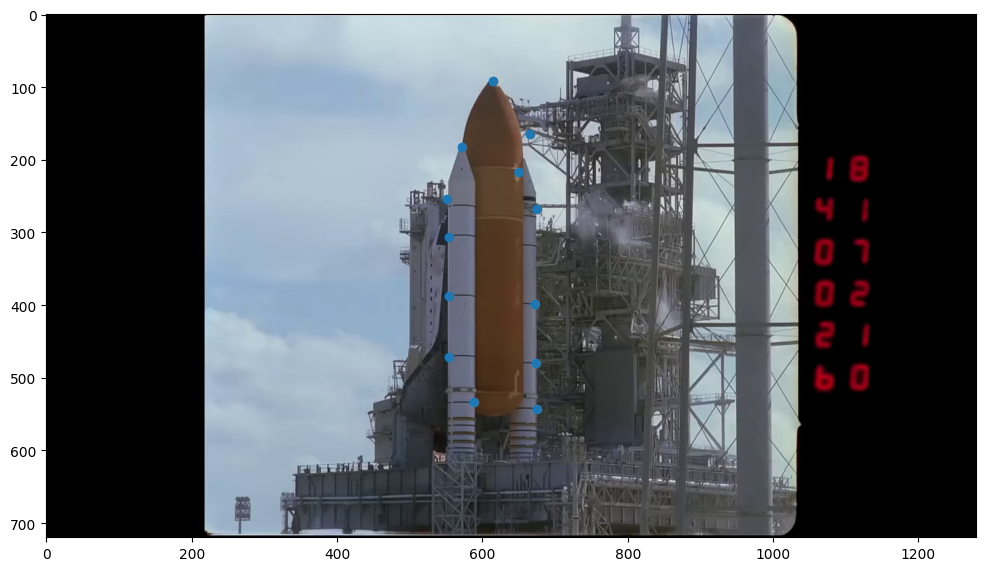

In [103]:
source = cv2.VideoCapture('./data/shuttle.mp4')
status, frame = source.read()
source.release()

h, w, c = frame.shape
mask = np.zeros((h, w), dtype=np.uint8)
mask[90:-165, 550:-600] = 1

rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
features = cv2.goodFeaturesToTrack(
    image=gray, 
    mask=mask,
    maxCorners=20, 
    qualityLevel=0.1,
    minDistance=50,
    blockSize=3,
    useHarrisDetector=False,
    k=0.04
)
fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.imshow(rgb)
ax.scatter(features[..., 0], features[..., 1]);

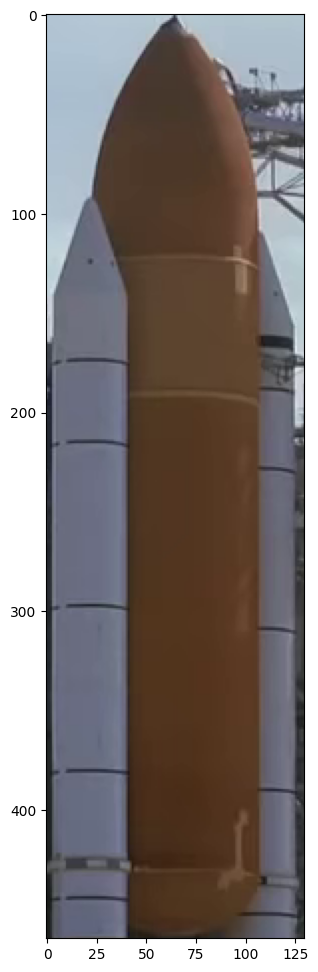

In [105]:
source = cv2.VideoCapture('./data/shuttle.mp4')
status, frame = source.read()
frame = frame[90:-165, 550:-600]
source.release()

rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.imshow(rgb);

In [108]:
TANK_HEIGHT_IN_PIXELS = 465  # sprawdzone doświadczalnie
MASK = np.zeros((720, 1280))
MASK[90:-165, 550:-600] = 1
TANK_HEIGHT_IN_METERS = 47 # netrów

### Zadanie 2

Uzupełnij daną poniżej podstawową pętlę analizy wideo o śledzenie obiektów: inicjalizację i wykorzystanie przepływu optycznego do aktualizacji ich położenia. Celem jest pozyskanie pełnej trajektorii pojazdu, tak aby można było ją narysować (np. [`cv2.polylines`](https://docs.opencv.org/3.4/d6/d6e/group__imgproc__draw.html#gaa3c25f9fb764b6bef791bf034f6e26f5)) tudzież przetwarzać dalej.

Zapoznaj się dobrze z dokumentacją funkcji [`cv2.calcOpticalFlowPyrLK`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323), zwłaszcza z wartościami zwracanymi, **zwłaszcza** `status`. Upewnij się, że odpowiednio obsługujesz przypadki niepowodzenia znalezienia przepływu dla poszczególnych punktów.

Wynik zaprezentuj w postaci graficznej (narysowane trajektorie).

In [3]:
def baseLoop(source: cv2.VideoCapture):
    frame1 = None
    status, frame2 = source.read()
    frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    # ...
    # inicjalizacja metody
    # ...
    while status:
        frame1 = frame2
        status, frame2 = source.read()
        frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
        # ...
        # przetwarzanie
        # ...

### Zadanie 3

Dokonaj analizy znalezionych trajektorii i znajdź prędkość _Discovery_. Wersja minimum: załóż, że pojazd porusza się z lokalnie stałą prędkością. Wersja normalna: wykreśl prędkość pojazdu jako funkcję czasu.

_Bonus dla chętnych: czy na podstawie tego materiału da się wyznaczyć TWR (thrust-to-weight ratio) maszyny?_